## Align to Chinook

In [1]:
import pysam
import os.path
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline

In [2]:
chin_ex = pd.read_excel(os.path.join('data','ref','chinook','Supplemental Table 1.xlsx'))
chin_ex.head()

,Locus,Chromosome,Duplicate,Arm,Position (cM),Region of population divergence,Paired-end annotation,Locus name from Larson et al. 2014,Outlier from Larson et al. 2014,Consensus Sequence
0,44207_x1,Ots01,1,p,0.00,0,NaN,NaN,NaN,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...
1,28051_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...
2,6689_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...
3,59778_x1,Ots01,1,p,0.55,0,NaN,NaN,NaN,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...
4,38781_x1,Ots01,1,p,0.55,0,PRTG,NaN,NaN,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...


In [3]:
chin_ex = chin_ex[['Locus', 'Consensus Sequence', 'Chromosome', 'Position (cM)']]
chin_ex['Locus_basename'] = [xx.split('_')[0] for xx in chin_ex['Locus'] ]
chin_ex.head()

,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,44207_x1,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...,Ots01,0.00,44207
1,28051_x1,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...,Ots01,0.55,28051
2,6689_x1,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...,Ots01,0.55,6689
3,59778_x1,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...,Ots01,0.55,59778
4,38781_x1,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...,Ots01,0.55,38781


drop duplicates, checking with locus basename and sequence

In [4]:
chin_ex.drop_duplicates(subset = ['Locus_basename', 'Consensus Sequence'], inplace = True)

check that each locus is now present only once

In [5]:
len(set(chin_ex['Locus_basename'])) == len(chin_ex['Locus_basename'])

True

In [6]:
with open(os.path.join('data','ref','chinook','chin_ref.fasta'), 'w') as OUTFILE:
    count = 0
    for index,  locus_row in chin_ex.iterrows():
        
        OUTFILE.write('>{}\n{}\n'.format(locus_row['Locus_basename'], locus_row['Consensus Sequence']))

### Align chum loci to chinook loci using bowtie 2 

In [7]:
chin_FASTA = 'chin_ref.fasta'

In [8]:
print('bowtie2-build {} chinook'.format(chin_FASTA))

bowtie2-build chin_ref.fasta chinook


chum ref

In [9]:
chum_ref = '/media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta'

align

In [10]:
SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.SAM'
filtered_SAM_output = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.filtered.SAM'

run bowtie 2

check directories here

In [11]:
print('bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Desktop/waples/chum_populations/data/ref/chinook/chinook -U {} -S {}'.format(chum_ref, SAM_output))

bowtie2 -f --local --very-sensitive -p 4 -x /home/ipseg/Desktop/waples/chum_populations/data/ref/chinook/chinook -U /media/Shared/Data/chum/populations/ref/paper_1/chum_paper_1_ref.CURATED.fasta -S /home/ipseg/Desktop/waples/chum_populations/results/batch_4/synteny/to_chinook.SAM


#### Examine reference

In [12]:
def get_aligns():
    return(pysam.AlignmentFile(SAM_output, "r").fetch())

### Mapping quality

In [13]:
mpqs = [read.mapping_quality for read in get_aligns()]

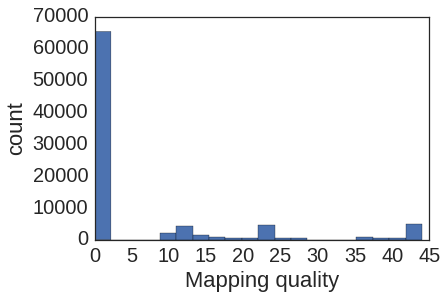

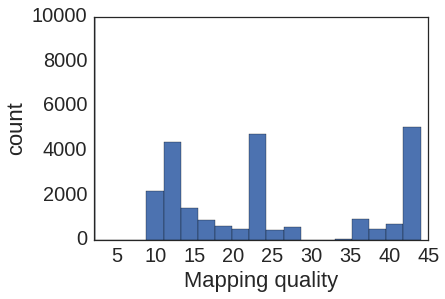

In [14]:
plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.show()

plt.hist(mpqs, bins = 20)
plt.xlabel('Mapping quality')
plt.ylabel('count')
plt.title('')
plt.xlim(2)
plt.ylim(0, 10000)
plt.show()

### As expected, there is strand bias

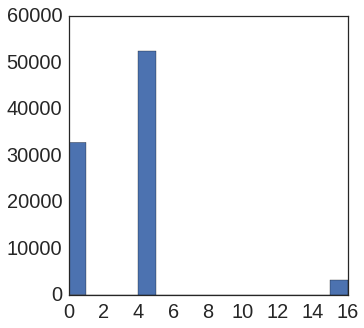

In [15]:
flags  = [read.flag for read in get_aligns()]
figsize(5,5)
plt.hist(flags, bins = 16)
plt.show()

### Alignment lengths

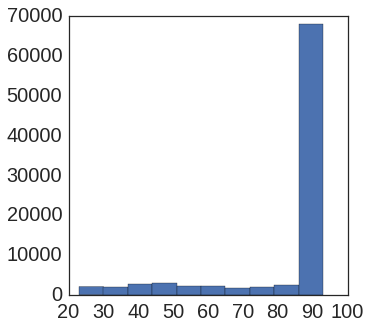

In [16]:
qal =  [read.query_alignment_length for read in get_aligns()]
plt.hist(qal)
plt.show()

### Edit distances

In [17]:
edit_distances = list()
mq = list()
for read in get_aligns():
    try:
        edit_distances.append(np.int(read.get_tag('XM')))
        mq.append(np.int(read.mapping_quality))
    except KeyError:
        pass

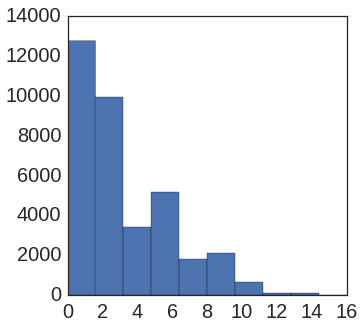

In [18]:
plt.hist(edit_distances)
plt.show()

### Edit distance vs Mapping quality

In [19]:
rr = pd.DataFrame({'ed' : edit_distances, 'mq' : mq })

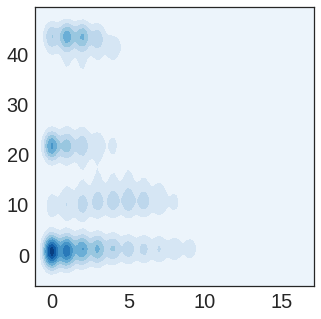

In [20]:
sns.kdeplot(rr, cmap="Blues", shade = True, legend = True)
plt.show()

#### Lets keep only the alignments with:
(query_alignment_length >= 93) AND (mapping_quality >= 30)

In [21]:
with pysam.AlignmentFile(SAM_output, "r") as INFILE:
    with pysam.AlignmentFile(filtered_SAM_output, "wh", template=INFILE) as OUTFILE:
        for aln in INFILE:
            if (aln.query_alignment_length >= 93) and (aln.mapping_quality >= 30):
                OUTFILE.write(aln)

In [22]:
filtered_SAM = pd.read_csv(filtered_SAM_output, sep = '\t', comment='@', engine='python', 
            names = ['QNAME','FLAG','RNAME','POS','MAPQ','CIGAR','RNEXT','PNEXT','ISIZE','SEQ','QUAL',
                     'TAG1', 'TAG2', 'TAG3' 'TAG4', 'TAG5', 'TAG6', 'TAG7','TAG8', 'TAG9','TAG10'])
filtered_SAM.head()

,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,ISIZE,SEQ,QUAL,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c6,0,66281,1,44,93M,*,0,0,TGCAGGTACTGCCTCTGCTTGGGCAGCCGCGGGGTCATCAGAGGGC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None
1,c5,0,16028,1,42,93M,*,0,0,TGCAGGCTGTGTCAGTTCATGAAGAACTACCTGCCCCGGGACTTCA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None
2,c14,0,7663,1,44,93M,*,0,0,TGCAGGAATATGAGAGGTTGTTCCAAATACAACTGTCTTTTCTGTT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None
3,c15,0,2732,1,44,93M,*,0,0,TGCAGGTTGTCCACCCTGGAGATGCAGTTCCCTGCCAGGTTCAACA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None
4,c16,0,86922,1,41,25M4I64M,*,0,0,TGCAGGTAACCACTAAAACCATGACCACACACACACACACAACCAA...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None


In [23]:
filtered_SAM.drop(['POS', 'RNEXT', 'PNEXT', 'ISIZE', 'SEQ','QUAL'], axis=1, inplace=True)
filtered_SAM['RNAME'] = [str(xx) for xx in filtered_SAM['RNAME'] ]
filtered_SAM.head()

,QNAME,FLAG,RNAME,MAPQ,CIGAR,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10
0,c6,0,66281,44,93M,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None
1,c5,0,16028,42,93M,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None
2,c14,0,7663,44,93M,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None
3,c15,0,2732,44,93M,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None
4,c16,0,86922,41,25M4I64M,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None


### Now merge with chum and chinook maps

In [24]:
chum_map = pd.read_csv(os.path.join('linkage_map', 'LEPmap', 'with_paralogs', 'final', 'PS_chum_map_2015.txt'), 
                       sep = '\t', header = 0)
chum_map.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM
0,c4311,4311,28282,28282_88,4584,1,0,1,0
1,c4311,4311,28282,28282_91,4584,1,0,1,0
2,c56875,56875,39970,39970_17,7377,1,0,1,0
3,c56875,56875,39970,39970_33,7377,1,0,1,0
4,c56875,56875,39970,39970_49,7377,1,0,1,0


In [25]:
chin_ex.head()

,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,44207_x1,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...,Ots01,0.00,44207
1,28051_x1,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...,Ots01,0.55,28051
2,6689_x1,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...,Ots01,0.55,6689
3,59778_x1,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...,Ots01,0.55,59778
4,38781_x1,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...,Ots01,0.55,38781


In [26]:
chin_lgs = pd.merge(filtered_SAM, chin_ex, left_on = 'RNAME' , right_on = 'Locus_basename')
chin_lgs.head()

,QNAME,FLAG,RNAME,MAPQ,CIGAR,TAG1,TAG2,TAG3TAG4,TAG5,TAG6,TAG7,TAG8,TAG9,TAG10,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,c6,0,66281,44,93M,AS:i:178,XN:i:0,XM:i:1,XO:i:0,XG:i:0,NM:i:1,MD:Z:41C51,YT:Z:UU,None,66281_x1,TGCAGGTACTGCCTCTGCTTGGGCAGCCGCGGGGTCATCAGCGGGC...,Ots26,54.09,66281
1,c5,0,16028,42,93M,AS:i:146,XN:i:0,XM:i:5,XO:i:0,XG:i:0,NM:i:5,MD:Z:6A17T41A1T8A15,YT:Z:UU,None,16028_x1,TGCAGGATGTGTCAGTTCATGAAGTACTACCTGCCCCGGGACTTCA...,Ots03,33.01,16028
2,c14,0,7663,44,93M,AS:i:186,XN:i:0,XM:i:0,XO:i:0,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None,7663_x1,TGCAGGAATATGAGAGGTTGTTCCAAATACAACTGTCTTTTCTGTT...,Ots15,25.62,7663
3,c15,0,2732,44,93M,AS:i:162,XN:i:0,XM:i:3,XO:i:0,XG:i:0,NM:i:3,MD:Z:37A9A20G24,YT:Z:UU,None,2732_x1,TGCAGGTTGTCCACCCTGGAGATGCAGTTCCCTGCCAAGTTCAACA...,Ots04,113.34,2732
4,c16,0,86922,41,25M4I64M,AS:i:137,XN:i:0,XM:i:3,XO:i:1,XG:i:4,NM:i:7,MD:Z:50C5G12C19,YT:Z:UU,None,86922_x1,TGCAGGTAACCACTAAAACCATGACCACACACACACAACCAACCAA...,Ots14,86.21,86922


In [27]:
synteny = pd.merge(chum_map, chin_lgs, left_on = 'contig' , right_on = 'QNAME')
synteny.drop_duplicates(subset=['contig'], inplace=True)
synteny.head()

,contig,resolved_locus,stacks_CatID,stacks_SNP,LEPname,LEP_LG,cM_OLD,paper1_LG,cM,QNAME,...,TAG6,TAG7,TAG8,TAG9,TAG10,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename
0,c44430,44430_A,29403,29403_58,4865,1,0.00,1,0.00,c44430,...,XO:i:0,XG:i:0,NM:i:3,MD:Z:16T41T21T12,YT:Z:UU,42094_x1,TGCAGGGCGCTGCGTTTGCCACACCTGGACAGTTCACATCAGGTAT...,Ots14,123.18,42094
1,c37517,37517,23631,23631_32,3764,1,2.95,1,2.95,c37517,...,XG:i:0,NM:i:0,MD:Z:93,YT:Z:UU,None,68945_x1,TGCAGGTATGAAAACAATATAGTTAAATACTAGTCGTGACCAGGTA...,Ots14,109.71,68945
2,c20050,20050,8866,8866_57,1701,1,4.84,1,4.84,c20050,...,XO:i:0,XG:i:0,NM:i:1,MD:Z:87C5,YT:Z:UU,60182_x1,TGCAGGACTTTTTGGAGTGTGGTGTCAAAAAAGCAGAGCATCTCTT...,Ots14,102.97,60182
4,c25287,25287,13325,13325_69,2352,1,4.84,1,4.84,c25287,...,XG:i:0,NM:i:2,MD:Z:74A9A8,YT:Z:UU,None,31266_x1,TGCAGGTTCGCAGGCATCCATCAATTAAGCAAACAGTTCAGAGGTT...,Ots14,109.71,31266
5,c33192,33192,20020,20020_28,3307,1,19.73,1,19.73,c33192,...,XG:i:0,NM:i:3,MD:Z:23T4G3G60,YT:Z:UU,None,34742_x1,TGCAGGTCAGTGCTAACCCCAACTAAGGGACAGAAGCTGTCATAAA...,Ots14,90.52,34742


In [28]:
synteny_summary = synteny[['contig', 'RNAME','paper1_LG', 'cM', 'Chromosome', 'Position (cM)']].copy()
synteny_summary.rename(columns = {'paper1_LG':'chum_LG', 'cM':'chum_cM', 'Chromosome':'Ots_LG', 'Position (cM)':'Ots_cM' }, inplace=True)
synteny_summary['Ots_LG'] = [int(xx.split('s')[1]) for xx in synteny_summary['Ots_LG']]
synteny_summary.head()

,contig,RNAME,chum_LG,chum_cM,Ots_LG,Ots_cM
0,c44430,42094,1,0.00,14,123.18
1,c37517,68945,1,2.95,14,109.71
2,c20050,60182,1,4.84,14,102.97
4,c25287,31266,1,4.84,14,109.71
5,c33192,34742,1,19.73,14,90.52


#### We need to establish a way to order the LG acoss species.  These species differ in the number of LGs, and these LGs do not necessarily have a 1:1 corrspondence.

Order for the chum <- numerical?

Order for chinook <- 
For each [Ots_LG] get the chum LG with the most co-located markers, ties go to earlier chum LGs


### Chum ordering

In [29]:
import collections

len_of_chum_LG = chum_map.groupby('paper1_LG').max()['cM'].to_dict()
len_of_chum_LG = collections.defaultdict(int, len_of_chum_LG)
print "total chum map length: {} cM".format(sum(len_of_chum_LG.values()))

total chum map length: 3027.23 cM


In [30]:
start_pos_of_chum_LG = collections.defaultdict(int)
for LG in range(1,38):
    start_pos_of_chum_LG[LG] = start_pos_of_chum_LG[LG-1] + len_of_chum_LG[LG-1] + 1

### Chinook ordering

In [31]:
matches = pd.DataFrame(synteny_summary.groupby('Ots_LG')['chum_LG'].value_counts())
matches.index.names =['Ots_LG', 'chum_LG']
matches.columns = ['matched_loci']
order_match = matches.reset_index(level=1).groupby(level=0).first()

In [32]:
chin_ex['Ots_LG'] = [int(xx.split('s')[1]) for xx in chin_ex['Chromosome'] ]
chin_ex.head()

,Locus,Consensus Sequence,Chromosome,Position (cM),Locus_basename,Ots_LG
0,44207_x1,TGCAGGTGTCTGCAAAAAAACACTCCCCTCCCTAGTTCTCCATATG...,Ots01,0.00,44207,1
1,28051_x1,TGCAGGCACCTGGACAGCCACAAGGAGTCGCTAGATTGTGATGAGC...,Ots01,0.55,28051,1
2,6689_x1,TGCAGGGAGAAACTTTGTAGTGGGGTGAAAAGAGGGAGAAGCATCG...,Ots01,0.55,6689,1
3,59778_x1,TGCAGGATATTAATGCAGGTAAGAAGAAATGGCTTTTAAATGTTTT...,Ots01,0.55,59778,1
4,38781_x1,TGCAGGAAGGGTCCTCTGGTGGACAACAGAACTCCAGGGACTGGAC...,Ots01,0.55,38781,1


get the length of each chinook chromosome

In [33]:
len_of_Ots_LG = chin_ex.groupby('Ots_LG').max()['Position (cM)'].to_dict()
len_of_Ots_LG = collections.defaultdict(int, len_of_Ots_LG)
print "total Ots map length: {} cM".format(sum(len_of_Ots_LG.values()))

total Ots map length: 3114.04 cM


In [34]:
start_pos_of_Ots_LG = collections.defaultdict(int)
current_len = 0
Ots_LG_order = order_match.sort(columns=['chum_LG', 'matched_loci']).index.tolist()

Ots_LG_order.pop(Ots_LG_order.index(1))
Ots_LG_order.insert(0 , 1)

Ots_LG_order.pop(Ots_LG_order.index(14))
Ots_LG_order.insert(0 , 14)



for LG in Ots_LG_order:
    start_pos_of_Ots_LG[LG] = current_len
    current_len += len_of_Ots_LG[LG]

In [35]:
def chum_pos(row):
    return (start_pos_of_chum_LG[row['chum_LG']] + row['chum_cM'])

def Ots_pos(row):
    return (start_pos_of_Ots_LG[row['Ots_LG']] + row['Ots_cM'])

synteny_summary['chum_pos'] = synteny_summary.apply(chum_pos, axis=1)
synteny_summary['Ots_pos'] = synteny_summary.apply(Ots_pos, axis=1)

synteny_summary.head(5)

,contig,RNAME,chum_LG,chum_cM,Ots_LG,Ots_cM,chum_pos,Ots_pos
0,c44430,42094,1,0.00,14,123.18,1.00,123.18
1,c37517,68945,1,2.95,14,109.71,3.95,109.71
2,c20050,60182,1,4.84,14,102.97,5.84,102.97
4,c25287,31266,1,4.84,14,109.71,5.84,109.71
5,c33192,34742,1,19.73,14,90.52,20.73,90.52


### Within each Ots LG, get the correlation (rho) of cM between it and the chum LG it matches.

In [36]:
import scipy.stats
rho_of_Ots_LG = dict()

for Ots_LG in order_match.index:
    chum_LG = order_match.loc[Ots_LG]['chum_LG']
    #print (Ots_LG, chum_LG)
    current_loci = synteny_summary[synteny_summary['Ots_LG'] == Ots_LG]
    current_loci = current_loci[current_loci['chum_LG'] == chum_LG]
    rho, pval = scipy.stats.spearmanr(a =current_loci['chum_pos'], b= current_loci['Ots_pos'])
    rho_of_Ots_LG[Ots_LG] = rho

### if this correlation is negative, invert the order of the loci in the chinook chromosome to match chum order

In [37]:
Ots_LGs_to_switch = [key for (key, val) in rho_of_Ots_LG.items() if val < 0]

In [38]:
def CLEAN_Ots_pos(row):
    if row['Ots_LG'] in Ots_LGs_to_switch:
        new_pos = row['Ots_pos'] - row['Ots_cM'] + len_of_Ots_LG[row['Ots_LG']] - row['Ots_cM']
        return(new_pos)
    else:
        return(row['Ots_pos'])

In [39]:
synteny_summary['CLEAN_Ots_pos'] = synteny_summary.apply(CLEAN_Ots_pos, axis = 1)

### Oxford Grid
sort so that color by LG works correctly

In [89]:
synteny_summary = synteny_summary.sort(columns = ['chum_LG', 'chum_cM'])
xx_breaks = start_pos_of_chum_LG.values()[1:]
yy_breaks = start_pos_of_Ots_LG.values()

xx_lab_loc = []
for idx, xx in enumerate(xx_breaks):
    try:
        xx_lab_loc.append((xx + xx_breaks[idx+1])/2.)
    except IndexError:
        xx_lab_loc.append(xx_breaks[idx]+50)

        
        
yy_lab_loc = []
for idx, yy in enumerate(yy_breaks):
    try:
        yy_lab_loc.append((yy + yy_breaks[idx+1])/2.)
    except IndexError:
        yy_lab_loc.append(yy_breaks[idx]+50)
        
# yy_breaks is not working - ordering is not 1.2.3...

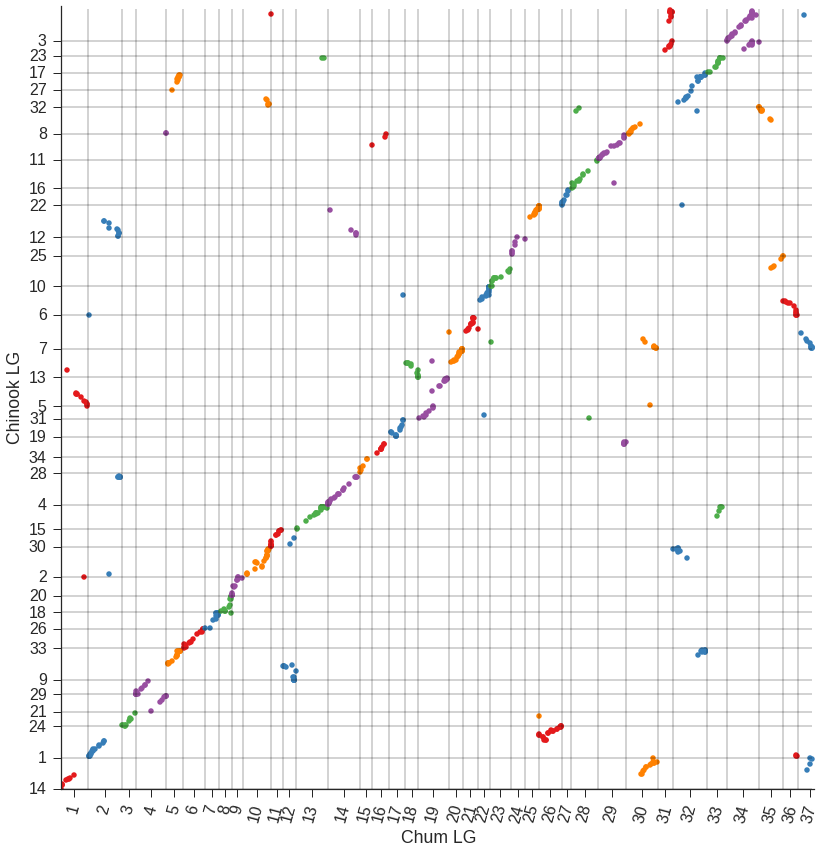

In [94]:
sns.set_context("talk")
sns.set(font_scale=1.6)
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

sns.lmplot('chum_pos', 'CLEAN_Ots_pos', data = synteny_summary, fit_reg = False, hue = 'chum_LG', legend = False,
           palette=sns.color_palette("Set1", 5), size = 12, scatter_kws = {'alpha':1, 's':30})
# plot limits
plt.xlim(0, synteny_summary['chum_pos'].max()+10)
plt.ylim(0, synteny_summary['Ots_pos'].max()+10)

# lines delimiting linkage groups
plt.vlines(xx_breaks, ymin = 0, ymax = synteny_summary['Ots_pos'].max(), alpha = .2)
plt.hlines(yy_breaks, xmin = 0, xmax = synteny_summary['chum_pos'].max(), alpha = .2)

# labels for x,y ticks and axes
plt.xticks(xx_lab_loc, range(1,38))
plt.yticks(yy_breaks, range(1,38))
plt.xlabel('Chum LG')
plt.ylabel('Chinook LG')

#rotate xticks
locs, labels = plt.xticks()
plt.setp(labels, rotation=75)

# save figure as png
plt.savefig(os.path.join('.' , 'paper', 'figures', 'supplemental','synteny_chinook.png'))
plt.show()

In [42]:
synteny_summary.head()

,contig,RNAME,chum_LG,chum_cM,Ots_LG,Ots_cM,chum_pos,Ots_pos,CLEAN_Ots_pos
0,c44430,42094,1,0.00,14,123.18,1.00,123.18,0.39
1,c37517,68945,1,2.95,14,109.71,3.95,109.71,13.86
2,c20050,60182,1,4.84,14,102.97,5.84,102.97,20.60
4,c25287,31266,1,4.84,14,109.71,5.84,109.71,13.86
5,c33192,34742,1,19.73,14,90.52,20.73,90.52,33.05


(-1, 38)

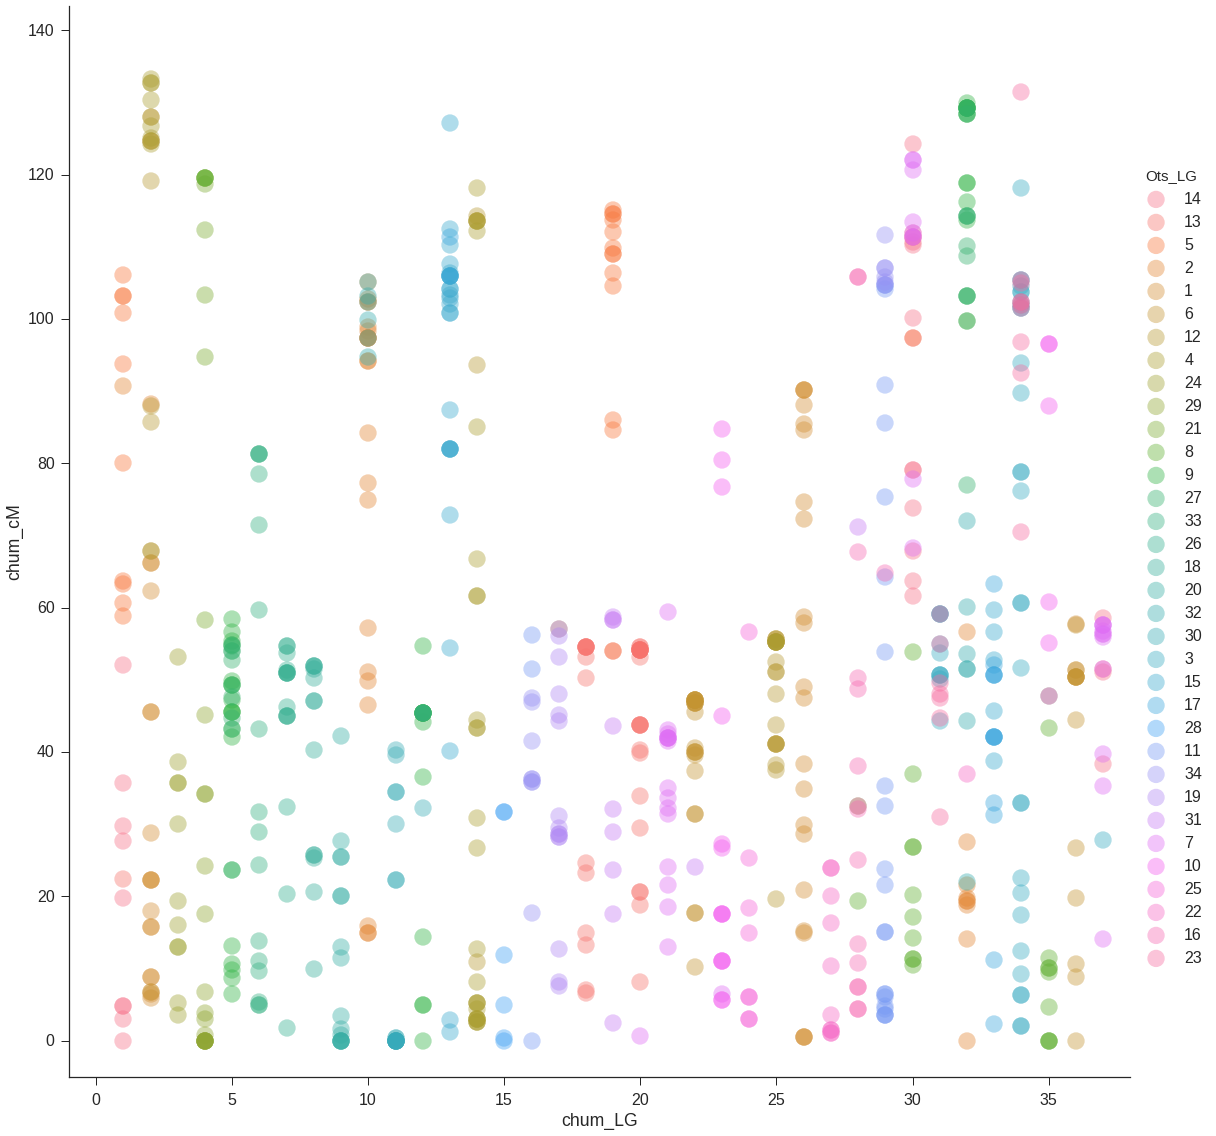

In [109]:
sns.lmplot('chum_LG', 'chum_cM', data = synteny_summary, fit_reg = False, hue = 'Ots_LG', legend = True,
           #palette=sns.color_palette("Set1", 34), 
           palette = sns.color_palette("husl", 34),
           size = 16, scatter_kws = {'alpha':.4, 's':300})

plt.ylim(-5, synteny_summary['chum_cM'].max()+10)
plt.xlim(-1, synteny_summary['chum_LG'].max()+1)

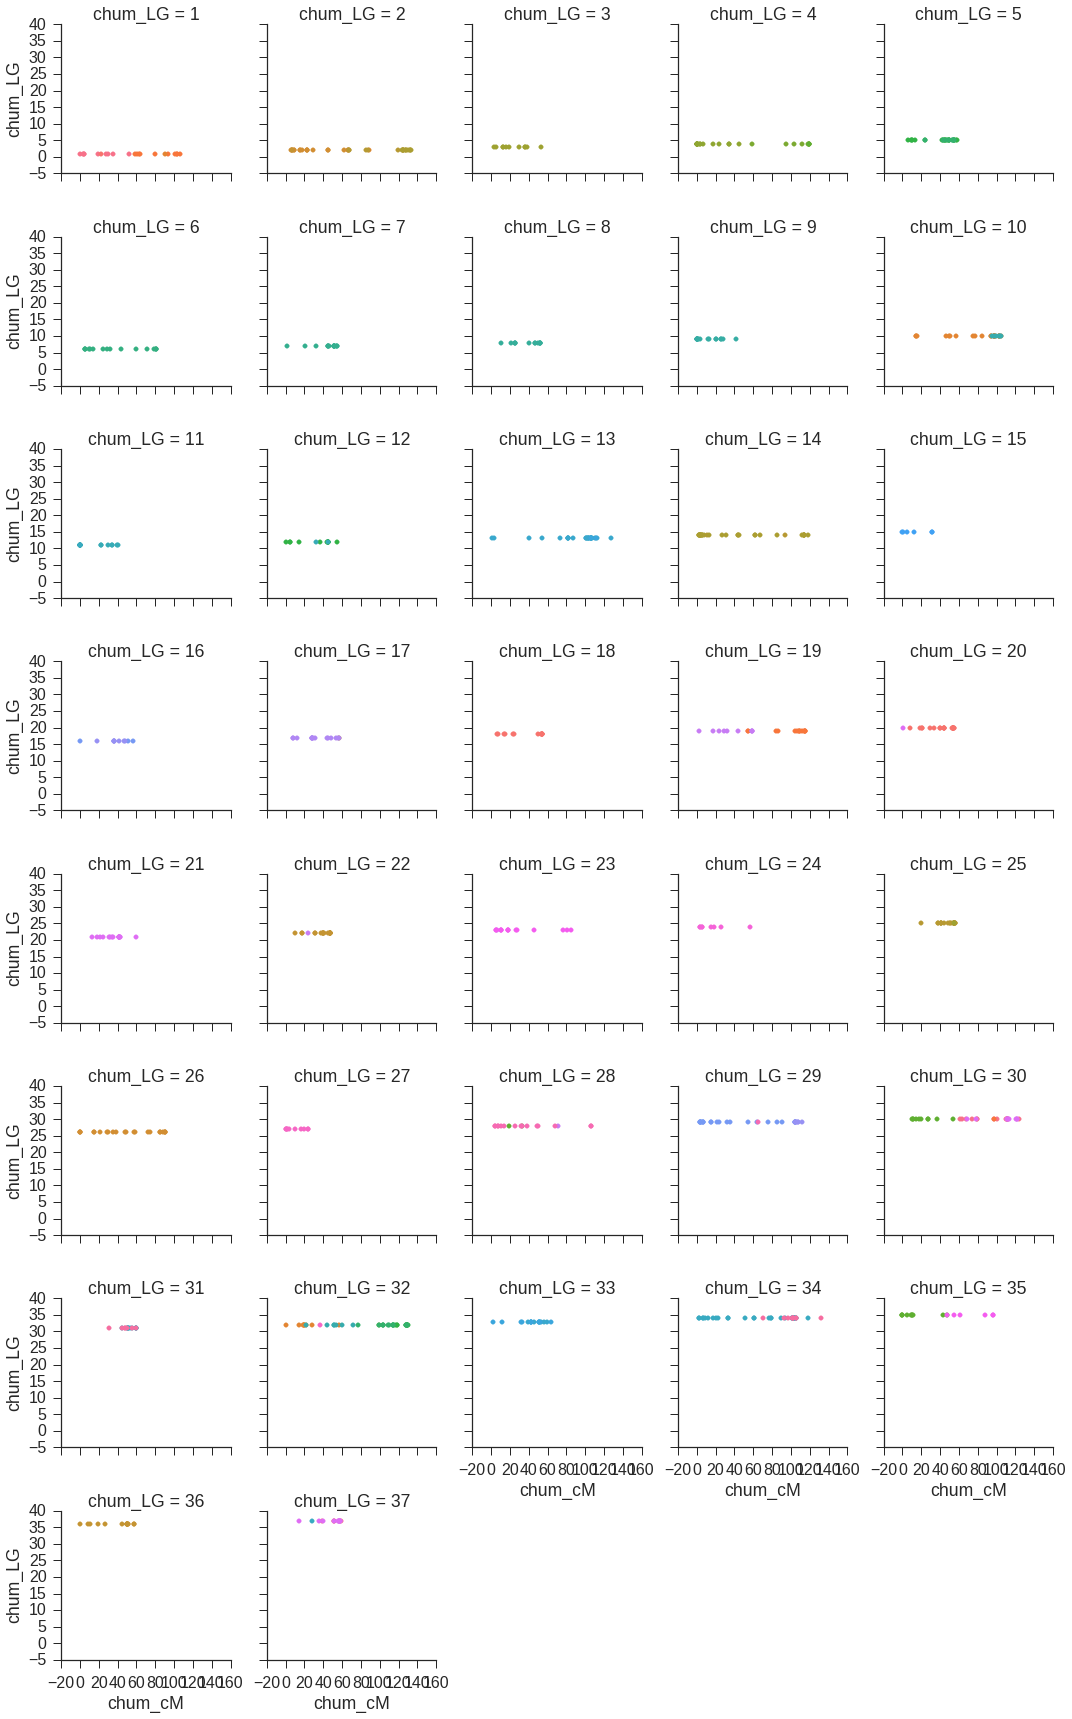

In [108]:
g = sns.FacetGrid(synteny_summary, col="chum_LG", hue = 'Ots_LG', col_wrap=5)
g = g.map(plt.scatter, 'chum_cM', 'chum_LG')

In [54]:
oxford_grid = synteny_summary.sort(columns = ['chum_LG', 'chum_cM']).copy()
oxford_grid['chum_pos'] = [ee for ee in range(len(oxford_grid))]
oxford_grid = oxford_grid.sort(columns = ['Ots_LG', 'Ots_cM'])

In [55]:
#yy = synteny_summary.sort(columns = ['Ots_LG', 'Ots_cM']).copy()
yy = synteny_summary.sort(columns = ['chum_LG', 'Ots_cM']).copy()
oxford_grid['Ots_pos'] = [ee for ee in range(len(yy))]

In [82]:
xx_breaks = np.where(np.diff(oxford_grid.sort(columns = ['chum_LG', 'chum_cM'])['chum_LG'])==1)
yy_breaks = np.where(np.diff(oxford_grid.sort(columns = ['Ots_LG', 'Ots_cM'])['Ots_LG'])==1)

In [ ]:
sns.lmplot('chum_pos', 'Ots_pos', data = synteny_summary, fit_reg = False, hue = 'chum_LG', legend = False,
           palette=sns.color_palette("Set1", 5), size = 13, scatter_kws = {'alpha':1, 's':40})
plt.xlim(0); plt.ylim(0)
#np.diff(xx.sort(columns = ['chum_LG', 'chum_cM'])['chum_LG'])
#plt.vlines(xx_breaks, ymin = 0, ymax = 770, alpha = .2)
#plt.hlines(yy_breaks, xmin = 0, xmax = 770, alpha = .2)
#plt.xticks([x-10 for x in xx_breaks[0]], range(1,38), horizontalalignment = 'left')
#plt.yticks([x-10 for x in yy_breaks[0]], range(1,38))
plt.xlabel('Chum LG')
plt.ylabel('Chinook LG')
plt.savefig(os.path.join('.' , 'paper', 'figures', 'supplemental','synteny_chinook.png'))
plt.show()

In [32]:
LG_vs_CHR = pd.crosstab(synteny['paper1_LG'], columns = synteny['Chromosome'])
LG_vs_CHR.index.name = 'Chum LG'

In [105]:
LG_vs_CHR.

Chromosome,Ots01,Ots02,Ots03,Ots04,Ots05,Ots06,Ots07,Ots08,Ots09,Ots10,...,Ots25,Ots26,Ots27,Ots28,Ots29,Ots30,Ots31,Ots32,Ots33,Ots34
Chum LG,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,1,0,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,16,0,0,0,0,0
5,0,0,0,0,0,0,0,0,19,0,...,0,0,10,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,0
7,0,0,0,0,0,0,0,0,0,0,...,0,15,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


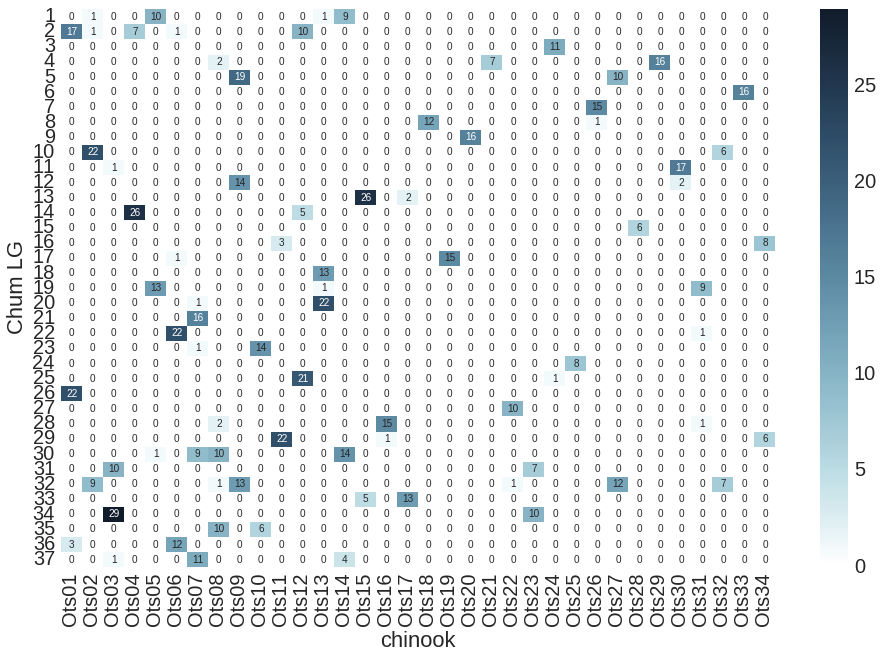

In [33]:
figsize(16,10)
my_colors = sns.cubehelix_palette(n_colors = 6, light=1, start = 2.8, rot = -.1, gamma = 1.2, as_cmap=True)
sns.heatmap(LG_vs_CHR, annot = True, linewidths = 0,square = False, cmap=my_colors, 
           cbar_kws={"orientation": "vertical"})
plt.xlabel('chinook')
plt.show()